# PCA on ensemble of reanalysis datasets

In [1]:
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition

from climvae.utils import utenso, preproc, eof, utdata, utstats, metric
import climvae.vaeplot as vpl

plt.style.use("../../paper.mplstyle")

## Load data

In [2]:
reload(utdata)
data_config = dict(
    multivar=False,
    variables=['sst'],
    source='reanalysis',
    timescale='monthly',
    lon_range=[130, -70],
    lat_range=[-31, 32],
#    lat_range=[-15, 16],
)
if (data_config['multivar'] is False) & (len(data_config['variables']) == 1):
    if data_config['timescale'] == 'monthly':
        dirpath = "../../data/sst/monthly"
        data_config['filenames'] = [
            dict(name='COBE2',   path=dirpath+"/sst_cobe2_month_1850-2019.nc"),
            dict(name='ErSSTv5', path=dirpath+"/sst_ersstv5_month_1854-present.nc"),
            dict(name='HadISST', path=dirpath+"/sst_hadisst_month_1870-present.nc"),
            dict(name='ORAS5',   path=dirpath+"/sst_t300_oras5_1958-2018.nc"),
            dict(name='GODAS',   path=dirpath+"/sst_godas_month_1980-present.nc"),
            dict(name='SODA',    path=dirpath+"/sst_SODA_month_1980-2017.nc"),
            dict(name='ERA5',    path=dirpath+"/sea_surface_temperature_era5_monthly_sp_1940-2022_1.0x1.0.nc"),
            dict(name='CERA-20c',    path=dirpath+"/sst_cera20c_1901-2009_r1x1.nc"),
            # dict(name='tropflux',path=dirpath+"/sst_tropflux_month_1979-2018.nc"),
        ]
        data_config['splity'] = ['2005-01-01', '2022-01-01']
    elif data_config['timescale'] == 'daily':
        data_config['filenames'] = [dict(
            name='era5',
            path=("../data/sst/daily/sea_surface_temperature_daily_coarse_1950_2021.nc")
        )]
        data_config['splity']=['2013-01-01', '2022-01-01']
elif data_config['multivar'] & (data_config['timescale'] == 'monthly'):
    data_config['filenames']=[
        dict(name='SODA',  path=f"../../data/multivar/oceanvars_SODA_1x1.nc"),
        dict(name='GODAS', path=f"../../data/multivar/oceanvars_GODAS_1x1.nc"),
        dict(name='ORAS5', path=f"../../data/multivar/oceanvars_ORAS5_1x1.nc"),
        dict(name='CERA-20c', path=f"../../data/multivar/oceanvars_CERA20C_1x1.nc"),
    ]
else:
    raise ValueError(f"No data are loaded due to specified timescale and variables!")

data_config['detrend_from'] = '1950'
data_config['normalization'] ='zscore'
# data_config['enso_types'] = ['Nino_EP', 'Nino_CP', 'Nina_CP','Nina_EP'] 

data = utdata.load_data(**data_config)
ds = data['full']

Open file COBE2
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Detrend and compute anomalies:
Open file ErSSTv5
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Detrend and compute anomalies:
Open file HadISST
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Detrend and compute anomalies:
Open file ORAS5
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid 

In [3]:
# Use only times which occur in all datasets
if False:
    for i, member in enumerate(np.unique(ds['member'])):
        idx_member = np.where(ds['member'] == member)[0]
        if i == 0:
            times = ds.isel(time=idx_member).time
        else:
            times = np.intersect1d(times, ds.isel(time=idx_member).time)

    # Select only common times
    ds4eof = []
    for i, member in enumerate(np.unique(ds['member'])):
        idx_member = np.where(ds['member'] == member)[0]
        ds4eof.append(ds.isel(time=idx_member).sel(time=times))

    ds4eof = xr.concat(ds4eof, dim='time')
else:
    ds4eof = ds

### EOF transformation

In [4]:
reload(eof)
n_components = 2
sppca = eof.SpatioTemporalPCA(ds4eof, n_components=n_components)
eofs = sppca.get_eofs()
pcs = sppca.get_principal_components()
print(f"Explained variance: {np.sum(sppca.explained_variance())}")

Explained variance: 0.48147561855154086


array([<GeoAxesSubplot: >, <GeoAxesSubplot: >], dtype=object)

/home/jakob/Software/mambaforge/envs/vaeenv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/jakob/Software/mambaforge/envs/vaeenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


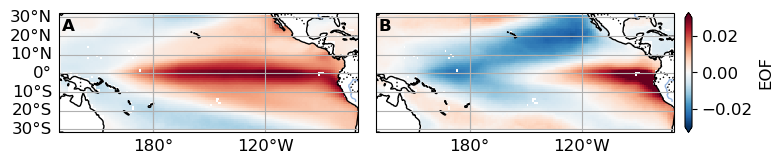

In [5]:
# EOF maps
reload(vpl)
vars = list(ds4eof.data_vars)
fig = plt.figure(figsize=(7, 2*len(vars)))
proj = ctp.crs.PlateCarree(central_longitude=180)
axs = []
for i in range(sppca.n_components):
    comp = eofs.isel(eof=i)
    for j, var in enumerate(vars):
        ax = fig.add_subplot(len(vars), sppca.n_components, i+sppca.n_components*j+1, projection=proj)
        im = vpl.plot_map(comp[var], central_longitude=180, ax=ax,
                     bar='continuous', vmin=-.03, vmax=.03, add_bar=False)
        im['gl'].top_labels = False 
        if i > 0:
            im['gl'].left_labels = False 
        axs.append(ax)
        
cbar_ax = fig.add_axes([0.99, .2, 0.01, 0.6])
cb = fig.colorbar(im['im'], cax=cbar_ax, orientation='vertical', shrink=0.6, extend='both')
cb.set_label(label=rf"EOF")

vpl.enumerate_subplots(axs, pos_x=.01, pos_y=.85)

#fig.savefig("../../output/paperplots/eofs_reanalysis.png", 
#            transparent=True, dpi=300, bbox_inches='tight')

### Get ENSO events

In [6]:
reload(utenso)
month_range=[12, 2]
x_enso, x_events = utenso.select_enso_events(ds, month_range=month_range)
z_enso = xr.DataArray(
    data=sppca.transform(x_enso),
    coords={'time': x_enso['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
).assign_coords(member=('time', x_enso['member'].data))
z_events = xr.DataArray(
    data=sppca.transform(x_events),
    coords={'time': x_events['time'].data, 'eof': np.arange(1, sppca.n_components+1)}
).assign_coords(member=('time', x_events['member'].data))

## Plot latent encoding

Text(0, 0.5, 'PC2')

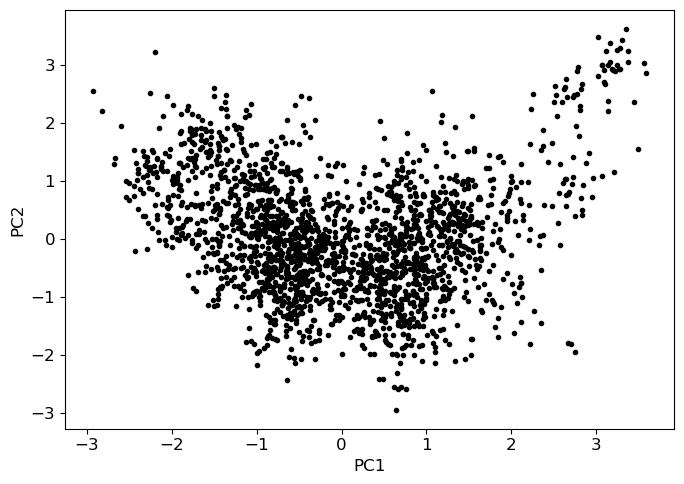

In [7]:
fig, ax = plt.subplots()
ax.plot(z_enso.isel(eof=0), z_enso.isel(eof=1), '.', color='k')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

Text(0, 0.5, 'PC2')

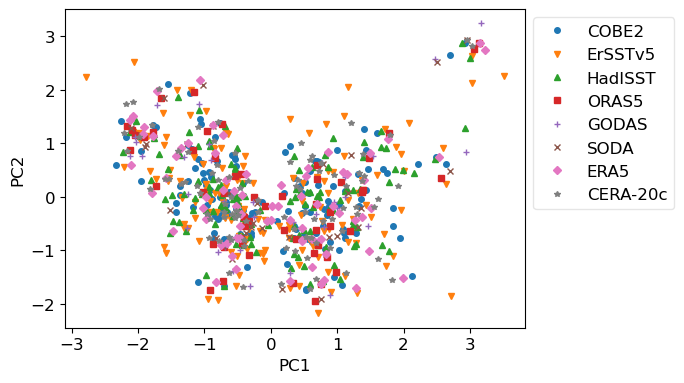

In [8]:
# Check differences between datasets
plparam = { 
    'COBE2':    dict(linestyle='', marker='o', markersize=4),
    'ErSSTv5':     dict(linestyle='', marker='v', markersize=4),
    'HadISST':  dict(linestyle='', marker='^', markersize=4), 
    'ORAS5':    dict(linestyle='', marker='s', markersize=4), 
    'GODAS':  dict(linestyle='', marker='+', markersize=4),
    'SODA':    dict(linestyle='', marker='x', markersize=4), 
    'ERA5':     dict(linestyle='', marker='D', markersize=4), 
    'CERA-20c':     dict(linestyle='', marker='*', markersize=4), 
}

fig, ax = plt.subplots(figsize=(7,4))
for i, dname in enumerate(data_config['filenames']):
    idx = np.where(x_events['member'].data == dname['name'])[0]
    ax.plot(z_events.isel(eof=0)[idx], z_events.isel(eof=1)[idx], label=dname['name'],
            **plparam[dname['name']])

ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

## Reconstruction loss

In [9]:
x_test, _ = utenso.select_enso_events(data['val'].dataset)
x_hat_test = sppca.reconstruction(x_test).transpose('time', 'lat', 'lon')
x_flat, _ = eof.map2flatten(x_test)
x_hat_flat, _ = eof.map2flatten(x_hat_test)
metric_dict = dict(
    var= "_".join(list(x_test.data_vars)), 
    z=sppca.pca.n_components,
    mse = ((x_hat_flat - x_flat)**2).mean(skipna=True).data,
    fuv=metric.fraction_unexplained_variance(x_flat.data, x_hat_flat.data),
)
metric_dict

{'var': 'ssta', 'z': 2, 'mse': array(0.6109986), 'fuv': 0.4236283312649186}

## Gaussian mixture 

### Scan number of cluster

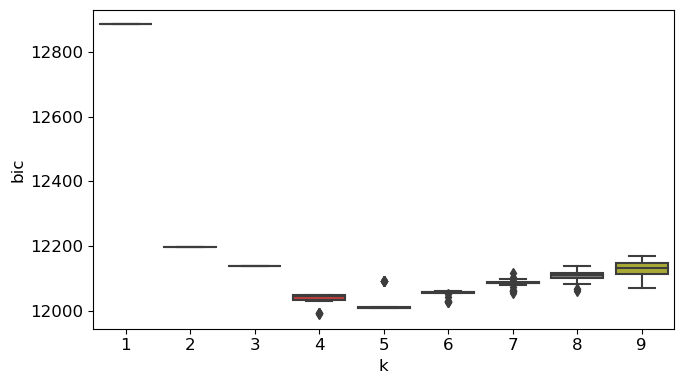

In [10]:
n_classes = np.arange(1, 10, 1)
n_runs = 50
result = []
for k in n_classes:
    for r in range(n_runs):
        gmm = mixture.GaussianMixture(n_components=k, 
                                      covariance_type='full', max_iter=100)
        gmm.fit(z_enso.data)
        result.append(
            {'k': k, 'bic': gmm.bic(z_enso.data), 'gmm': gmm}
        )
result = pd.DataFrame(result)

fig, ax = plt.subplots(figsize=(7,4))
ax = sns.boxplot(data=result, x='k', y='bic', ax=ax)

### Plot GMM

/home/jakob/Software/mambaforge/envs/vaeenv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


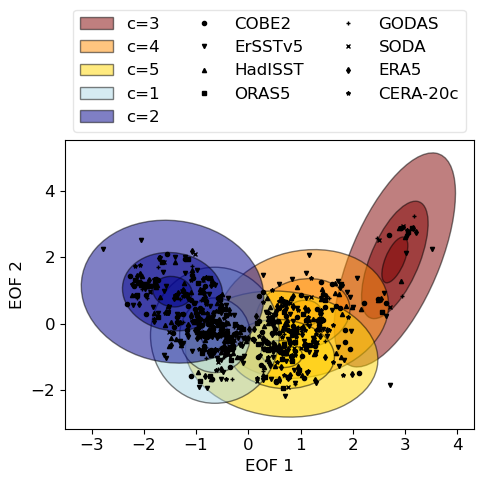

In [11]:
# Train GMM
n_cluster=5
n_rand = 42 # np.random.randint(0,1000)
gmm_pca = mixture.GaussianMixture(n_components=n_cluster, 
                      covariance_type='full', max_iter=100,
                      random_state=n_rand)
gmm_pca.fit(z_enso.data)

# Plotting
plparam = { 
    'COBE2':    dict(linestyle='', marker='o', markersize=3),
    'ErSSTv5':  dict(linestyle='', marker='v', markersize=3),
    'HadISST':  dict(linestyle='', marker='^', markersize=3), 
    'ORAS5':    dict(linestyle='', marker='s', markersize=3), 
    'GODAS':    dict(linestyle='', marker='+', markersize=3),
    'SODA':     dict(linestyle='', marker='x', markersize=3), 
    'ERA5':     dict(linestyle='', marker='d', markersize=3), 
    'CERA-20c': dict(linestyle='', marker='*', markersize=3), 
}

fig, ax = plt.subplots(figsize=(5,5))

# Plot gmm means
gmm_order = np.arange(gmm_pca.means_.shape[0]) 
gmm_order = np.array([3, 4, 5, 1, 2]) -1 # all sst 
#gmm_order = [3,1,2,4,0] # ssta lon=[-15, 15]
# gmm_order = [1,3,2,0,4] # ssta, ssha
gmclrs = ['maroon', 'darkorange', 'gold', 'lightblue', 'darkblue', 'black']
for i, k in enumerate(gmm_order):
    mean = gmm_pca.means_[k, :]
    if gmm_pca.covariance_type == "full":
        Sigma = gmm_pca.covariances_[k, :]
    elif gmm_pca.covariance_type == "diag":
        Sigma = np.diag(gmm_pca.covariances_[k, :])

    gmkwargs= dict(fill=False)
    if gmclrs is not None:
        gmkwargs['ec'] = 'k' #gmclrs[i] 
        gmkwargs['fc'] = gmclrs[i] 
        gmkwargs['fill'] = True
        gmkwargs['alpha'] = 0.5

    for p in [0.9, 0.5, 0.1]:
        if p==0.1:
            gmkwargs['label'] = f"c={k+1}"
        vpl.plot_2dgaussian(mean, Sigma,
                             ax=ax, p=p, **gmkwargs)

ax.set_xlabel("EOF 1")
ax.set_ylabel("EOF 2")

for i, dname in enumerate(data_config['filenames']):
    idx = np.where(x_events['member'].data == dname['name'])[0]
    ax.plot(z_events.isel(eof=0)[idx], z_events.isel(eof=1)[idx], color='k', label=dname['name'],
            **plparam[dname['name']])

ax.legend(bbox_to_anchor=(0., 1.0, 1., 0.1), loc="lower left", ncol=3, mode='expand')

fig.savefig("../../output/paperplots/pcgmm_latent.png", 
            transparent=True, dpi=300, bbox_inches='tight')

/tmp/ipykernel_10936/4059304366.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("../../output/paperplots/pcgmm_mean_decoding.png",
/home/jakob/Software/mambaforge/envs/vaeenv/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/jakob/Software/mambaforge/envs/vaeenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


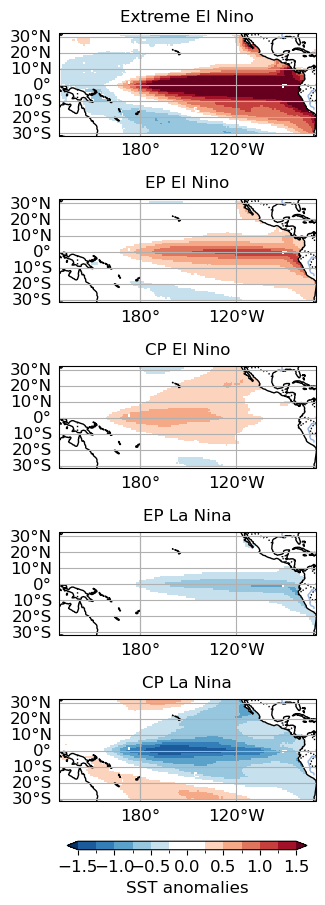

In [12]:
# Plot mean of Gaussian mixtures
plparam = {'ssta': dict(vmin=-1.5, vmax=1.5, step=0.25, cmap='RdBu_r', centercolor="#ffffff"),
           'ssha': dict(vmin=-.15, vmax=.15, step=0.025,cmap='RdGy_r', centercolor="#ffffff")}
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]

means = sppca.inverse_transform(gmm_pca.means_, newdim='mu')
# Unnormalize
if data_config['normalization'] is not None:
    for var in list(ds.data_vars):
        means[var] = ds.attrs[var]['normalizer'].inverse_transform(means[var])

vars = ds.data_vars
fig = plt.figure(figsize=(4*len(vars), 1.7*len(gmm_order)))
proj = ctp.crs.PlateCarree(central_longitude=180)
for i, k in enumerate(gmm_order):
    mu = means.sel(mu=k)
    for j, var in enumerate(vars):
        idx = len(vars)*i+j+1
        ax = fig.add_subplot(len(gmm_order), len(vars), idx, projection=proj)
        im = vpl.plot_map(mu[var], central_longitude=180, ax=ax, 
                          bar='discrete', add_bar=False, **plparam[var])
        im['gl'].top_labels = False 
#        ax.set_title(rf"$c_{k+1}$", fontsize=14)
        ax.set_title(labels[i], fontsize=12)

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -.01, 0.6, 0.01])
cbar = plt.colorbar(im['im'], orientation='horizontal', shrink=0.7,
                    cax=cbar_ax, extend='both')
cbar.set_label(f"SST anomalies", size=12)
fig.savefig("../../output/paperplots/pcgmm_mean_decoding.png", 
            transparent=True, dpi=300, bbox_inches='tight')

In [13]:
# Save means
if False:
    means.attrs['gmm_sort'] = gmm_order
    means.to_netcdf("../../output/reanalysis/pcgmm/pcgmm_means_sst_lat_30.nc")

## Probabilistic weights

In [14]:
# Event weights
p_c_given_x = utenso.posterior_weights(
    z_events.data, means=gmm_pca.means_, covariances=gmm_pca.covariances_,
    prior_weights=gmm_pca.weights_
)
# convert to xarray
p_c_given_x_da = xr.DataArray(data=p_c_given_x, dims=['time', 'classes'], 
                              coords={ 
                                'time': z_events['time'].data,
                                'member': ('time', z_events['member'].data),
                                'classes': np.arange(p_c_given_x.shape[1]) + 1
                              })

# Mean posterior weights
timepoints = np.unique(p_c_given_x_da['time'].data)
p_c_given_x_mean = []
p_c_given_x_std = []
for t in timepoints:
    weight = p_c_given_x_da.sel(time=t)
    if len(weight.shape) > 1:
        p_c_given_x_mean.append(weight.mean(dim='time').data)
        p_c_given_x_std.append(weight.std(dim='time').data)
    else:
        p_c_given_x_mean.append(weight.data)
        p_c_given_x_std.append(np.zeros(shape=5))

p_c_given_x_mean = xr.DataArray(data=p_c_given_x_mean, coords={'time':timepoints, 'classes':p_c_given_x_da['classes']})        
p_c_given_x_std = xr.DataArray(data=p_c_given_x_std, coords={'time':timepoints, 'classes':p_c_given_x_da['classes']})        

array([<AxesSubplot: ylabel='$p(c_3|z)$'>,
       <AxesSubplot: ylabel='$p(c_4|z)$'>,
       <AxesSubplot: ylabel='$p(c_5|z)$'>,
       <AxesSubplot: ylabel='$p(c_1|z)$'>,
       <AxesSubplot: ylabel='$p(c_2|z)$'>], dtype=object)

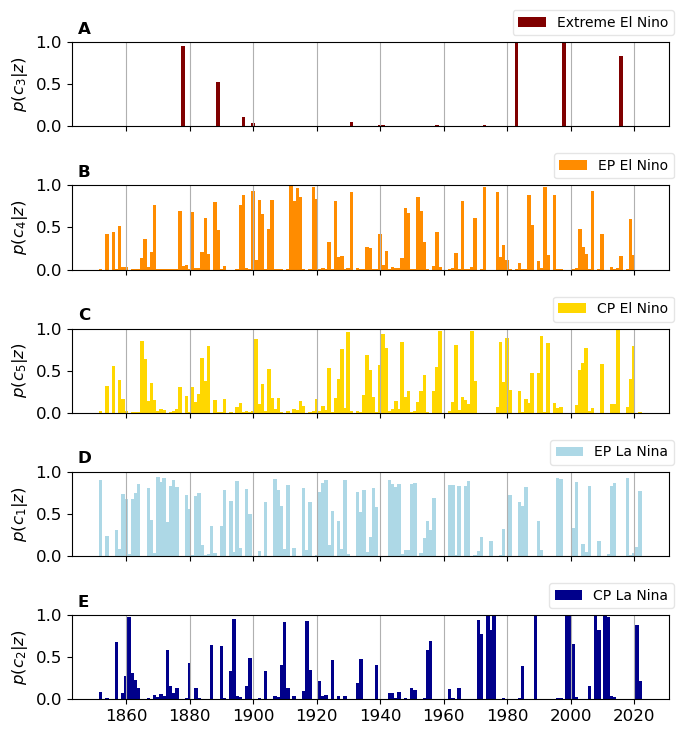

In [15]:
#  Plot posterior weights
reload(vpl)
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]
n_samples, n_classes = p_c_given_x.shape
fig, axs = plt.subplots(n_classes, 1, figsize=(7, 1.5*n_classes), sharex='col', sharey='row')

for i, k in enumerate(gmm_order):
    axs[i].bar(p_c_given_x_mean['time'].data, height=p_c_given_x_mean.sel(classes=k+1),
                 width=4e2, color=gmclrs[i], label=labels[i])
    axs[i].grid(axis='x')
    axs[i].set_ylabel(rf'$p(c_{k+1}|z)$')
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0, .5, 1])
#    axs[i].legend(loc=1, fontsize=10)
    axs[i].legend(bbox_to_anchor=(.72, 1.0, 0.3, 0.1), loc="lower right", fontsize=10)

vpl.enumerate_subplots(axs, pos_x=0.01, pos_y=1.1, fontsize=12)

#fig.savefig("../../output/paperplots/pcgmm_weights_mean.png", 
#            transparent=True, dpi=300, bbox_inches='tight')

In [16]:
k = 4
buff = p_c_given_x_mean.sel(time=slice('1950-01-01', None), classes=k)
idx = np.where(buff > 0.1)[0]
for t in buff['time'][idx]:
    print(f"{np.datetime64(t.data, 'Y')}: {buff.sel(time=t).data :.2f}")

1951: 0.87
1952: 0.70
1953: 0.33
1957: 0.44
1963: 0.19
1965: 0.81
1969: 0.61
1972: 0.98
1976: 0.92
1977: 0.15
1978: 0.30
1979: 0.11
1986: 0.88
1987: 0.52
1989: 0.11
1991: 0.99
1992: 0.17
1994: 0.89
2002: 0.49
2003: 0.27
2004: 0.18
2006: 0.93
2009: 0.42
2015: 0.16
2018: 0.59
2019: 0.17


In [17]:
# Print years of clear events
buff = p_c_given_x_mean.sel(time=slice('1950-01-01', None))
for k in gmm_order:
    idx = np.where(buff.sel(classes=k+1) >= 0.90)[0]
    print(f"Events c={k+1}: {np.array(buff['time'][idx].data, dtype='datetime64[Y]')}")

# Print p(c|x) for a given x
temp_prob = p_c_given_x_mean.sel(time=np.datetime64("1951-12-15", 'D'), method='nearest')
print(temp_prob)

Events c=3: ['1982' '1997']
Events c=4: ['1972' '1976' '1991' '2006']
Events c=5: ['1958' '1968' '1990' '2014']
Events c=1: ['1995' '1996' '2017']
Events c=2: ['1970' '1973' '1975' '1988' '1998' '1999' '2007' '2010' '2011']
<xarray.DataArray (classes: 5)>
array([2.16616448e-03, 2.46264074e-04, 1.87534204e-06, 8.65834027e-01,
       1.31751669e-01])
Coordinates:
    time     datetime64[ns] 1951-12-01
  * classes  (classes) int64 1 2 3 4 5


array([<AxesSubplot: ylabel='$\\sigma ( p(c_3|z))$'>,
       <AxesSubplot: ylabel='$\\sigma ( p(c_4|z))$'>,
       <AxesSubplot: ylabel='$\\sigma ( p(c_5|z))$'>,
       <AxesSubplot: ylabel='$\\sigma ( p(c_1|z))$'>,
       <AxesSubplot: ylabel='$\\sigma ( p(c_2|z))$'>], dtype=object)

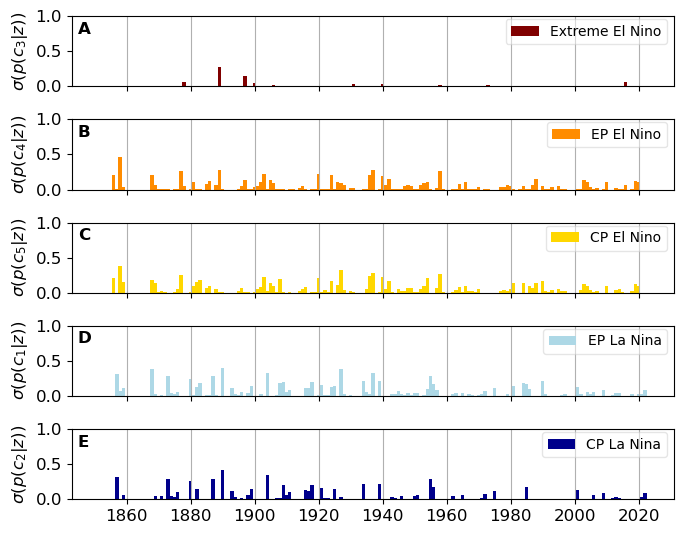

In [41]:
# Std of weights between datasets
labels = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]
fig, axs = plt.subplots(n_classes, 1, figsize=(7, 1.1*n_classes), sharex='col', sharey='row')

for i, k in enumerate(gmm_order):
    axs[i].bar(p_c_given_x_std['time'].data, height=p_c_given_x_std.sel(classes=k+1),
                 width=4e2, color=gmclrs[i], label=rf"{labels[i]}")
    axs[i].grid(axis='x')
    axs[i].set_ylabel(rf'$\sigma ( p(c_{k+1}|z))$')
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0, .5, 1])
    axs[i].legend(bbox_to_anchor=(.7, .5, 0.3, 0.1), loc="lower right", fontsize=10)

vpl.enumerate_subplots(axs, pos_x=0.01, pos_y=.75, fontsize=12)

#fig.savefig("../../output/paperplots/pcgmm_weights_std.png", 
#            transparent=True, dpi=300, bbox_inches='tight')

Compute monthly weights

In [19]:
# Monthly weights
p_c_given_x_month = utenso.posterior_weights(
    z_enso.data, means=gmm_pca.means_, covariances=gmm_pca.covariances_,
    prior_weights=gmm_pca.weights_
)
# convert to xarray
p_c_given_x_month = xr.DataArray(data=p_c_given_x_month, dims=['time', 'classes'], 
                              coords={ 
                                'time': z_enso['time'].data,
                                'member': ('time', z_enso['member'].data),
                                'classes': np.arange(p_c_given_x_month.shape[1]) + 1
                              })

# Mean posterior weights
timepoints = np.unique(p_c_given_x_month['time'].data)
weight_month_mean = []
weight_month_std = []
for t in timepoints:
    weight = p_c_given_x_month.sel(time=t)
    if len(weight.shape) > 1:
        weight_month_mean.append(weight.mean(dim='time').data)
        weight_month_std.append(weight.std(dim='time').data)
    else:
        weight_month_mean.append(weight.data)
        weight_month_std.append(np.zeros(shape=5))

weight_month_mean = xr.DataArray(data=weight_month_mean, coords={'time':timepoints, 'classes':p_c_given_x_month['classes']})        
weight_month_std = xr.DataArray(data=weight_month_std, coords={'time':timepoints, 'classes':p_c_given_x_month['classes']})        

In [20]:
# Save probability weights
if False:
    p_c_given_x_mean.attrs['gmm_sort'] = gmm_order
    p_c_given_x_mean.name = 'p_c_given_x'
    p_c_given_x_mean.to_netcdf("../../output/reanalysis/pcgmm/pcgmm_weights_events_mean_sst.nc")
if False:
    weight_month_mean.attrs['gmm_sort'] = gmm_order
    weight_month_mean.name = 'p_c_given_x'
    weight_month_mean.to_netcdf("../../output/reanalysis/pcgmm/pcgmm_weights_mon_mean_sst.nc")

### Histogram plot of the Nino3.4

In [21]:
product = 'HadISST' #'COBE2','ErSSTv5','HadISST', 'ORAS5', 'GODAS', 'SODA', 'ERA5', 'CERA-20c' 
for fnames in data_config['filenames']:
    if fnames['name'] == product:
        filepath = fnames['path']
    
ssta = preproc.process_data(
        filepath, vars=['sst'], antimeridian=True,
        climatology='month', normalization=None, detrend_from=1950 
)['ssta']
nino_indices = utenso.get_nino_indices(ssta, antimeridian=True)

Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Detrend and compute anomalies:


Monthly weights:

In [22]:
nino_indices = nino_indices.sel(time=slice(None, '2021-12-31'))

In [23]:
weights = weight_month_mean
nino34 = nino_indices['nino34']
# Make sure weights and nino-indices are on the same time points
tmax = nino34['time'].max() if nino34['time'].max() < weights['time'].max() else weights['time'].max()
tmin = nino34['time'].min() if nino34['time'].min() > weights['time'].min() else weights['time'].min()
nino34 = nino34.sel(time=slice(tmin.data, tmax.data)).rolling(time=3, center=True).mean()
weights = weights.sel(time=slice(tmin.data, tmax.data))
weights['time'] = np.array(weights['time'].data, dtype='datetime64[M]')
nino34['time'] = np.array(nino34['time'].data, dtype='datetime64[M]')

nino34 = nino34.sel(time=weights['time'])

array([<AxesSubplot: ylabel='Nino3.4'>, <AxesSubplot: xlabel='density'>],
      dtype=object)

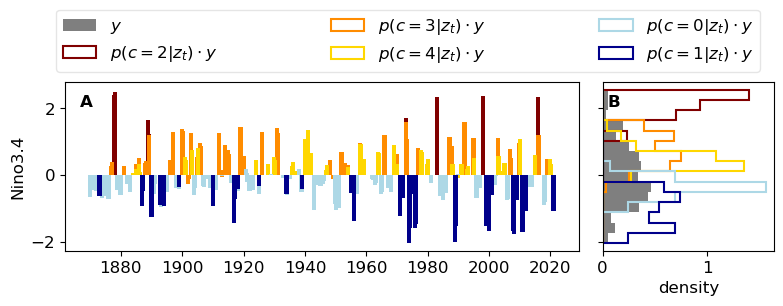

In [24]:
fig, axs = plt.subplots(1, 2, 
                        width_ratios=[3,1],
                        figsize=(8, 2.5),
                        sharey=True)
#axs[0].bar(nino34['time'].data, height=nino34.data, width=4e2, label=rf'y', color='k')
im, bins, _ = axs[1].hist(nino34.data, bins='auto', density=True, orientation='horizontal',
                          histtype='bar', color='k', alpha=.5, label=rf'$y$')
for i, k in enumerate(gmm_order):
    n34_k = nino34 * weights.sel(classes=k+1)
    idx_nonzero = np.where(weights.sel(classes=k+1).data > 0.55)[0]
    n34_k = n34_k[idx_nonzero]
    axs[0].bar(n34_k['time'].data, height=n34_k.data, width=5e2,
                   color=gmclrs[i])#, label=rf'$p(c={k}|z_t) \cdot y$')
    axs[1].hist(n34_k.data, bins=bins, density=True, orientation='horizontal',
                histtype='step', color=gmclrs[i], linewidth=1.5, #alpha=.4,
                label=rf'$p(c={k}|z_t) \cdot y$')

axs[0].set_ylabel(f'$p_i \cdot y$')
axs[0].set_ylabel("Nino3.4")
axs[1].set_xlabel("density")
#axs[1].legend(bbox_to_anchor=(1., .1, .6, 1.), loc="lower left", ncol=1)
fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.07, 1.15, .9, 0.1), mode='expand')
vpl.enumerate_subplots(axs, pos_x=0.03, pos_y=.85, fontsize=12)

### Decadal variability

In [25]:
nino34 = nino34.sel(time=slice("1855-12-01", None))
weights = weights.sel(time=slice("1855-12-01", None)) 

In [26]:
nino34_k = []
for k in weights['classes']:
    nino34_k.append(nino34 * weights.sel(classes=k))

nino34_k = xr.concat(nino34_k, dim=pd.Index(weights['classes'].data, name='classes'))

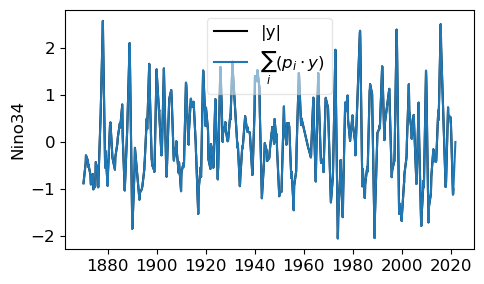

In [27]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(nino34['time'].data, nino34.data, color='k', label="|y|")
ax.plot(nino34_k['time'].data, nino34_k.sum(dim='classes'), label=r"$\sum_i (p_i \cdot y)$")
ax.set_ylabel('Nino34')
ax.legend()

Rolling window

In [28]:
def rolling_window_covariance(da: xr.DataArray, window_size: int):
    covs = []
    times = []
    for i in range(window_size-1, len(da['time'])):
        # Select window
        chunk = da.isel(time=slice(i-window_size+1, i+1))
        # Compute covariance
        cov = np.cov(chunk.data)
        covs.append(cov)
        times.append(chunk.isel(time=int(window_size/2))['time'].data)
    
    return np.array(covs), np.array(times)

n_years = 20
nino34_var, times = rolling_window_covariance(nino34, window_size=3*n_years)
nino34_var = xr.DataArray(nino34_var, coords=dict(time=times))
nino34_k_cov, times = rolling_window_covariance(nino34_k, window_size=3*n_years)
nino34_k_cov = xr.DataArray(nino34_k_cov, coords=dict(time=times, c1=nino34_k['classes'].data, c2=nino34_k['classes'].data))


In [29]:
# Sum of covariances
n_times, n_features, _ = nino34_k_cov.shape
sum_covariances = np.zeros(n_times)
for i in range(n_features):
    for j in range(i+1, n_features):
        sum_covariances += nino34_k_cov.data[:, i, j]
nino34_k_cov_sum = xr.DataArray(2*sum_covariances, coords=dict(time=nino34_k_cov['time'].data))

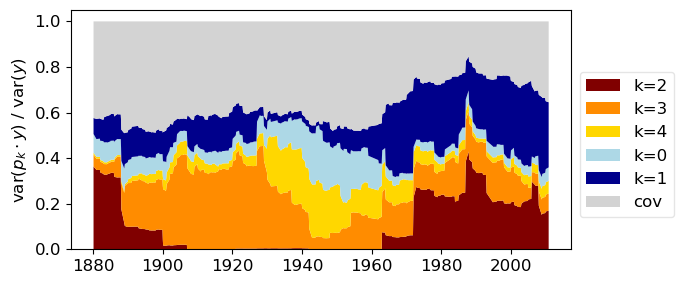

In [30]:
# Continueous stackplot
stacked_lines = [(nino34_k_cov.isel(c1=k, c2=k) / nino34_var
                  ) for k in gmm_order]
stacked_lines.append(
    nino34_k_cov_sum / nino34_var
)

# Labels
labels = [rf"k={k}" for k in gmm_order]
labels.append("cov")
# Colors
clrs = gmclrs[:len(gmm_order)]
clrs.append('lightgrey')

fig, ax = plt.subplots(figsize=(7,3))
ax.stackplot(nino34_var['time'], *stacked_lines, colors=clrs, labels=labels)
#ax.plot(nino34_var['time'], nino34_var.data, '--', color='green')

ax.set_ylabel(r"var($p_k \cdot y$) / var($y$)")
ax.legend(bbox_to_anchor=(1., .1, .6, 1.), loc="lower left", ncol=1)


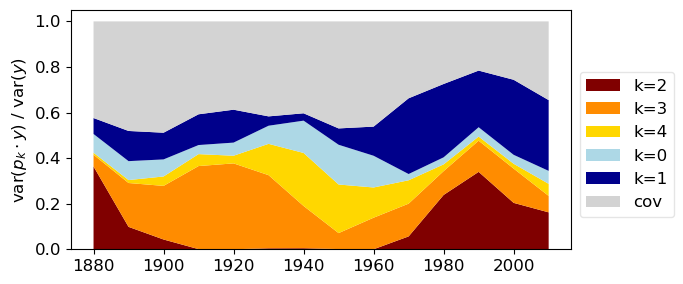

In [31]:
# Stack plot every 10 years
n_step = 10
# Time points
year_arr = np.arange(np.array(nino34_k_cov['time'].min().data, dtype='datetime64[Y]'),
                     np.array(nino34_k_cov['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                     step=n_step, dtype='datetime64[Y]')
#time_arr = nino34_k_cov.sel(
#    time=np.array([f"{y}-01-01" for y in year_arr], dtype='datetime64[D]'), method='nearest'
#    )['time']
time_arr = np.array([f"{y}-01-01" for y in year_arr], dtype='datetime64[D]')
# Select time points and stack plots
stacked_lines = [(nino34_k_cov.sel(time=time_arr, method='nearest').isel(c1=k, c2=k) / nino34_var
                  ) for k in gmm_order]
stacked_lines.append(
    nino34_k_cov_sum.sel(time=time_arr, method='nearest') / nino34_var
)

fig, ax = plt.subplots(figsize=(7,3))
ax.stackplot(time_arr, *stacked_lines, colors=clrs, labels=labels)

ax.set_xticks(time_arr[::2])
ax.set_xticklabels(np.array(time_arr[::2], dtype='datetime64[Y]'))
ax.set_ylabel(r"var($p_k \cdot y$) / var($y$)")
ax.legend(bbox_to_anchor=(1., .1, .6, 1.), loc="lower left", ncol=1)


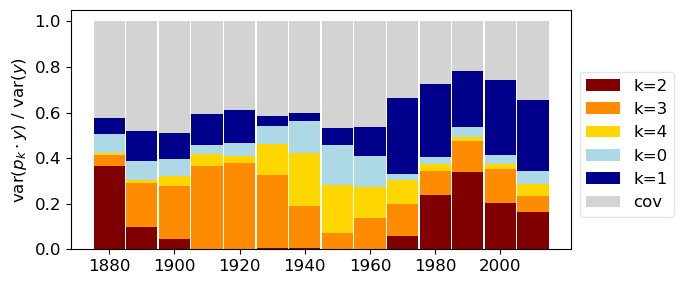

In [32]:
# Bar plot every 10 years
fig, ax = plt.subplots(figsize=(7,3))
bottom = np.zeros_like(stacked_lines[0])
for i, stack in enumerate(stacked_lines):
    ax.bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[i], label=labels[i])
    bottom += stack

ax.set_xticks(time_arr[::2])
ax.set_xticklabels(np.array(time_arr[::2], dtype='datetime64[Y]'))
ax.set_ylabel(r"var($p_k \cdot y$) / var($y$)")
ax.legend(bbox_to_anchor=(1., .1, .6, 1.), loc="lower left", ncol=1)


### Combine hist and decadel plot

array([<AxesSubplot: ylabel='Nino3.4'>, <AxesSubplot: xlabel='density'>,
       <AxesSubplot: ylabel='variance'>,
       <AxesSubplot: ylabel='norm. variance'>], dtype=object)

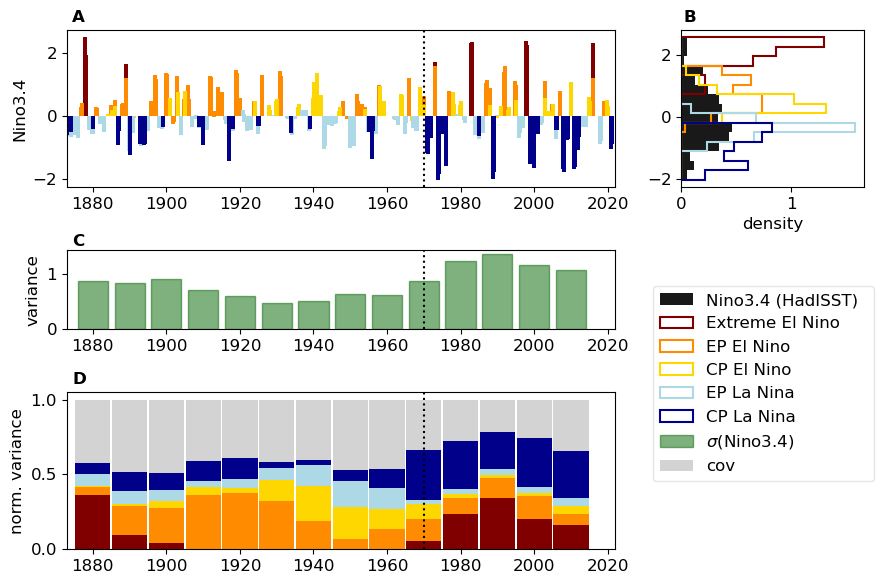

In [33]:
import matplotlib.gridspec as gridspec
class_names = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina',]
nrows, ncols = (3, 2)
fig = plt.figure(figsize=(9, nrows*2.))
gs = gridspec.GridSpec(nrows, ncols, width_ratios=[3,1], height_ratios=[2,1,2])
axs = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]
axs.append(fig.add_subplot(gs[1,0], sharex=axs[0]))
axs.append(fig.add_subplot(gs[2,0], sharex=axs[0]))
axs.append(fig.add_subplot(gs[1:,1]))

# Nino34 time-series and hisplot
im, bins, _ = axs[1].hist(nino34.data, bins='auto', density=True, orientation='horizontal',
                          histtype='bar', color='k', alpha=.9, label=f'Nino3.4 ({product})')
for i, k in enumerate(gmm_order):
    n34_k = nino34 * weights.sel(classes=k+1)
    idx_nonzero = np.where(weights.sel(classes=k+1).data > 0.5)[0]
    n34_k = n34_k[idx_nonzero]
    axs[0].bar(n34_k['time'].data, height=n34_k.data, width=4e2,
                   color=gmclrs[i])
    axs[1].hist(n34_k.data, bins=bins, density=True, orientation='horizontal',
                histtype='step', color=gmclrs[i], linewidth=1.5, #alpha=.4,
                label=class_names[i])
#                label=r'$p(c_{k}|z_t) \cdot y$'.replace('k', str(k+1)))
axs[0].set_xlim(np.min(n34_k['time']).data, np.max(n34_k['time']).data)
axs[0].set_ylabel("Nino3.4")
axs[0].axvline(np.datetime64('1970-01-01'), ls=':', color='k')

axs[1].set_xlabel(r"density")

# Variance of Nino34
years = np.arange(np.array(nino34_var['time'].min().data, dtype='datetime64[Y]'),
                  np.array(nino34_var['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                  step=10, dtype='datetime64[Y]')
variance = nino34_var.sel(time=years, method='nearest')
#axs[2].plot(nino34_var['time'], nino34_var, color='darkgreen',
#           label=r'$\sigma_{30y}$ (Nino3.4)')
#axs[2].fill_between(nino34_var['time'], np.zeros(len(nino34_var['time'])), nino34_var, color='darkgreen', alpha=.5)
axs[2].bar(years, height=variance, width=3e3, color='darkgreen', edgecolor='darkgreen', alpha=.5, 
           label=r'$\sigma$(Nino3.4)')
axs[2].set_ylabel(r"variance")
axs[2].axvline(np.datetime64('1970-01-01'), ls=':', color='k')

# Decadel variability
bottom = np.zeros_like(stacked_lines[0])
for i, stack in enumerate(stacked_lines):
    axs[3].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[i], label=labels[i])
    bottom += stack
axs[3].set_ylabel(r"norm. variance")
axs[3].axvline(np.datetime64('1970-01-01'), ls=':', color='k')

# Legend in seperate subplot
hands, labs = axs[1].get_legend_handles_labels()
hand2, lab2 = axs[2].get_legend_handles_labels()
hand3, lab3 = axs[3].get_legend_handles_labels()
hands.append(hand2[-1])
hands.append(hand3[-1])
labs.append(lab2[-1])
labs.append(lab3[-1])
axs[4].legend(hands, labs, bbox_to_anchor=(-.2, .2, 1.3, 1.), loc="lower left", mode='expand')
axs[4].axis('off')

# Hatch area
#t_min = np.min(n34_k['time'])
#t_max = np.max(n34_k['time'])
#for ax in [axs[2], axs[3]]:
#    ax.fill_between(
#        np.arange(t_min.data, np.min(variance['time']).data, dtype='datetime64[Y]')-4, 0, 1,
#        color='w', hatch='xx', edgecolor='black', alpha=0.5,
#        transform=ax.get_xaxis_transform()
#    )
#    ax.fill_between(
#        np.arange(np.max(variance['time']).data, t_max.data, dtype='datetime64[Y]')+5, 0, 1,
#        color='w', hatch='xx', edgecolor='black', alpha=0.5,
#        transform=ax.get_xaxis_transform()
#    )



vpl.enumerate_subplots(axs[:4], pos_x=0.01, pos_y=1.05, fontsize=12)

### Check consistency with duration of window

array([<AxesSubplot: ylabel='$\\overline{\\sigma}$ (w=20y)'>,
       <AxesSubplot: ylabel='$\\overline{\\sigma}$ (w=30y)'>,
       <AxesSubplot: ylabel='$\\overline{\\sigma}$ (w=40y)'>],
      dtype=object)

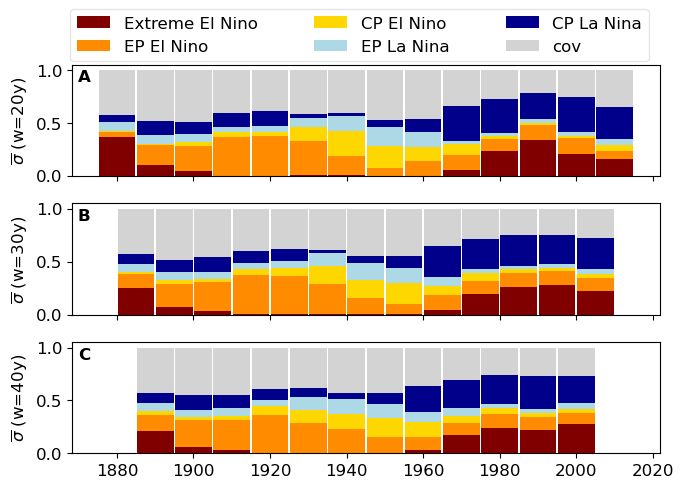

In [42]:
n_step = 10
window_arr = [20, 30, 40]
nrows = len(window_arr) 
class_names = ['Extreme El Nino', 'EP El Nino', 'CP El Nino', 'EP La Nina', 'CP La Nina', 'cov']
#labels = [rf"k={k}" for k in gmm_order]

fig, axs = plt.subplots(nrows, 1, figsize=(7, nrows*1.5), sharex=True)


for i, n_years in enumerate(window_arr):
    nino34_var, times = rolling_window_covariance(nino34, window_size=3*n_years)
    nino34_var = xr.DataArray(nino34_var, coords=dict(time=times))
    nino34_k_cov, times = rolling_window_covariance(nino34_k, window_size=3*n_years)
    nino34_k_cov = xr.DataArray(nino34_k_cov, coords=dict(time=times, c1=nino34_k['classes'].data, c2=nino34_k['classes'].data))
    
    # Sum of covariances
    n_times, n_features, _ = nino34_k_cov.shape
    sum_covariances = np.zeros(n_times)
    for j in range(n_features):
        for k in range(j+1, n_features):
            sum_covariances += nino34_k_cov.data[:, j, k]
    nino34_k_cov_sum = xr.DataArray(2*sum_covariances, coords=dict(time=nino34_k_cov['time'].data))
    
    year_arr = np.arange(np.array(nino34_k_cov['time'].min().data, dtype='datetime64[Y]'),
                         np.array(nino34_k_cov['time'].max().data, dtype='datetime64[Y]') + np.timedelta64(2, 'Y'),
                         step=n_step, dtype='datetime64[Y]')
    time_arr = np.array([f"{y}-01-01" for y in year_arr], dtype='datetime64[D]')
    # Select time points and stack plots
    stacked_lines = [(nino34_k_cov.sel(time=time_arr, method='nearest').isel(c1=k, c2=k) / nino34_var
                      ) for k in gmm_order]
    stacked_lines.append(
        nino34_k_cov_sum.sel(time=time_arr, method='nearest') / nino34_var
    )

    # Decadel variability
    bottom = np.zeros_like(stacked_lines[0])
    for j, stack in enumerate(stacked_lines):
        if i == 0:
            axs[i].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[j], label=class_names[j])
        else:
            axs[i].bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[j])
        bottom += stack
    axs[i].set_ylabel(r"$\overline{\sigma}$ " + f"(w={n_years}y)")

fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.1, 1.0, .85, 0.1), mode='expand')
vpl.enumerate_subplots(axs, pos_x=0.01, pos_y=.85, fontsize=12)


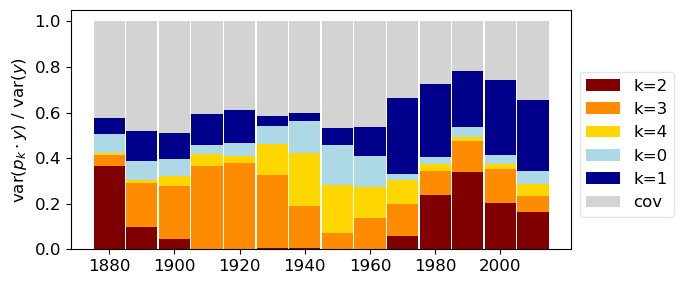

In [ ]:
# Bar plot every 10 years
fig, ax = plt.subplots(figsize=(7,3))
bottom = np.zeros_like(stacked_lines[0])
for i, stack in enumerate(stacked_lines):
    ax.bar(time_arr, stack, bottom=bottom, width=3.5e3, color=clrs[i], label=labels[i])
    bottom += stack

ax.set_xticks(time_arr[::2])
ax.set_xticklabels(np.array(time_arr[::2], dtype='datetime64[Y]'))
ax.set_ylabel(r"var($p_k \cdot y$) / var($y$)")
ax.legend(bbox_to_anchor=(1., .1, .6, 1.), loc="lower left", ncol=1)
